## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=0.0, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

Dropout_EXP = [0.1, 0.2, 0.4]
L2_EXP = [1e-4, 1e-8, 1e-12, 0.0]


In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for drp_rate, l2r in itertools.product(Dropout_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Experiment with DP ={drp_rate}, L2 = {l2r}")
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=l2r, drp_ratio=drp_rate)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = f"exp-PD-{drp_rate}-l2-{l2r}"
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with DP =0.1, L2 = 0.0001
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalizati

Epoch 46/50
49/49 [==============================] - 2s 46ms/step - loss: 1.2858 - accuracy: 0.5892 - val_loss: 1.4718 - val_accuracy: 0.5257
Epoch 47/50
49/49 [==============================] - 2s 46ms/step - loss: 1.2780 - accuracy: 0.5919 - val_loss: 1.4873 - val_accuracy: 0.5237
Epoch 48/50
49/49 [==============================] - 2s 46ms/step - loss: 1.2655 - accuracy: 0.5967 - val_loss: 1.4737 - val_accuracy: 0.5257
Epoch 49/50
49/49 [==============================] - 2s 47ms/step - loss: 1.2589 - accuracy: 0.6005 - val_loss: 1.4734 - val_accuracy: 0.5307
Epoch 50/50
49/49 [==============================] - 2s 46ms/step - loss: 1.2495 - accuracy: 0.6025 - val_loss: 1.4725 - val_accuracy: 0.5260
Experiment with DP =0.1, L2 = 1e-08
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
__________________________________

Epoch 41/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1949 - accuracy: 0.5736 - val_loss: 1.3462 - val_accuracy: 0.5239
Epoch 42/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1912 - accuracy: 0.5750 - val_loss: 1.3466 - val_accuracy: 0.5237
Epoch 43/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1830 - accuracy: 0.5774 - val_loss: 1.3535 - val_accuracy: 0.5150
Epoch 44/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1766 - accuracy: 0.5793 - val_loss: 1.3430 - val_accuracy: 0.5280
Epoch 45/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1652 - accuracy: 0.5849 - val_loss: 1.3495 - val_accuracy: 0.5215
Epoch 46/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1580 - accuracy: 0.5864 - val_loss: 1.3378 - val_accuracy: 0.5238
Epoch 47/50
49/49 [==============================] - 2s 49ms/step - loss: 1.1516 - accuracy: 0.5885 - val_loss: 1.3465 - val_accuracy: 0.5260
Epoch 

Epoch 36/50
49/49 [==============================] - 2s 48ms/step - loss: 1.2426 - accuracy: 0.5569 - val_loss: 1.3692 - val_accuracy: 0.5141
Epoch 37/50
49/49 [==============================] - 2s 48ms/step - loss: 1.2302 - accuracy: 0.5603 - val_loss: 1.3642 - val_accuracy: 0.5135
Epoch 38/50
49/49 [==============================] - 2s 48ms/step - loss: 1.2242 - accuracy: 0.5623 - val_loss: 1.3738 - val_accuracy: 0.5079
Epoch 39/50
49/49 [==============================] - 2s 48ms/step - loss: 1.2129 - accuracy: 0.5679 - val_loss: 1.3633 - val_accuracy: 0.5091
Epoch 40/50
49/49 [==============================] - 2s 48ms/step - loss: 1.2001 - accuracy: 0.5752 - val_loss: 1.3697 - val_accuracy: 0.5121
Epoch 41/50
49/49 [==============================] - 2s 48ms/step - loss: 1.1932 - accuracy: 0.5740 - val_loss: 1.3690 - val_accuracy: 0.5146
Epoch 42/50
49/49 [==============================] - 2s 48ms/step - loss: 1.1851 - accuracy: 0.5794 - val_loss: 1.3649 - val_accuracy: 0.5148
Epoch 

Epoch 31/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2835 - accuracy: 0.5429 - val_loss: 1.3768 - val_accuracy: 0.5130
Epoch 32/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2760 - accuracy: 0.5466 - val_loss: 1.3767 - val_accuracy: 0.5132
Epoch 33/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2682 - accuracy: 0.5500 - val_loss: 1.3769 - val_accuracy: 0.5127
Epoch 34/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2578 - accuracy: 0.5529 - val_loss: 1.3675 - val_accuracy: 0.5142
Epoch 35/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2514 - accuracy: 0.5549 - val_loss: 1.3583 - val_accuracy: 0.5186
Epoch 36/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2384 - accuracy: 0.5586 - val_loss: 1.3644 - val_accuracy: 0.5154
Epoch 37/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2331 - accuracy: 0.5603 - val_loss: 1.3584 - val_accuracy: 0.5206
Epoch 

Epoch 26/50
49/49 [==============================] - 2s 49ms/step - loss: 1.6278 - accuracy: 0.4661 - val_loss: 1.5841 - val_accuracy: 0.4764
Epoch 27/50
49/49 [==============================] - 2s 49ms/step - loss: 1.6166 - accuracy: 0.4727 - val_loss: 1.5664 - val_accuracy: 0.4854
Epoch 28/50
49/49 [==============================] - 2s 49ms/step - loss: 1.6069 - accuracy: 0.4725 - val_loss: 1.5578 - val_accuracy: 0.4921
Epoch 29/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5997 - accuracy: 0.4745 - val_loss: 1.5613 - val_accuracy: 0.4848
Epoch 30/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5880 - accuracy: 0.4803 - val_loss: 1.5454 - val_accuracy: 0.4944
Epoch 31/50
49/49 [==============================] - 2s 49ms/step - loss: 1.5818 - accuracy: 0.4830 - val_loss: 1.5536 - val_accuracy: 0.4894
Epoch 32/50
49/49 [==============================] - 2s 49ms/step - loss: 1.5717 - accuracy: 0.4858 - val_loss: 1.5534 - val_accuracy: 0.4841
Epoch 

Epoch 21/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5361 - accuracy: 0.4482 - val_loss: 1.4611 - val_accuracy: 0.4828
Epoch 22/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5243 - accuracy: 0.4578 - val_loss: 1.4478 - val_accuracy: 0.4881
Epoch 23/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5168 - accuracy: 0.4571 - val_loss: 1.4382 - val_accuracy: 0.4939
Epoch 24/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5016 - accuracy: 0.4649 - val_loss: 1.4388 - val_accuracy: 0.4875
Epoch 25/50
49/49 [==============================] - 2s 48ms/step - loss: 1.4948 - accuracy: 0.4667 - val_loss: 1.4310 - val_accuracy: 0.4916
Epoch 26/50
49/49 [==============================] - 2s 48ms/step - loss: 1.4827 - accuracy: 0.4705 - val_loss: 1.4269 - val_accuracy: 0.4965
Epoch 27/50
49/49 [==============================] - 2s 49ms/step - loss: 1.4770 - accuracy: 0.4709 - val_loss: 1.4130 - val_accuracy: 0.4999
Epoch 

Epoch 16/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5890 - accuracy: 0.4311 - val_loss: 1.4986 - val_accuracy: 0.4651
Epoch 17/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5851 - accuracy: 0.4335 - val_loss: 1.4851 - val_accuracy: 0.4743
Epoch 18/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5661 - accuracy: 0.4432 - val_loss: 1.4779 - val_accuracy: 0.4749
Epoch 19/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5549 - accuracy: 0.4440 - val_loss: 1.4715 - val_accuracy: 0.4724
Epoch 20/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5472 - accuracy: 0.4484 - val_loss: 1.4596 - val_accuracy: 0.4829
Epoch 21/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5365 - accuracy: 0.4515 - val_loss: 1.4520 - val_accuracy: 0.4826
Epoch 22/50
49/49 [==============================] - 2s 48ms/step - loss: 1.5286 - accuracy: 0.4560 - val_loss: 1.4443 - val_accuracy: 0.4851
Epoch 

Epoch 11/50
49/49 [==============================] - 2s 46ms/step - loss: 1.6866 - accuracy: 0.3981 - val_loss: 1.5794 - val_accuracy: 0.4441
Epoch 12/50
49/49 [==============================] - 2s 46ms/step - loss: 1.6688 - accuracy: 0.4050 - val_loss: 1.5600 - val_accuracy: 0.4464
Epoch 13/50
49/49 [==============================] - 2s 46ms/step - loss: 1.6527 - accuracy: 0.4103 - val_loss: 1.5432 - val_accuracy: 0.4491
Epoch 14/50
49/49 [==============================] - 2s 46ms/step - loss: 1.6339 - accuracy: 0.4167 - val_loss: 1.5269 - val_accuracy: 0.4551
Epoch 15/50
49/49 [==============================] - 2s 46ms/step - loss: 1.6176 - accuracy: 0.4234 - val_loss: 1.5285 - val_accuracy: 0.4587
Epoch 16/50
49/49 [==============================] - 2s 46ms/step - loss: 1.6047 - accuracy: 0.4279 - val_loss: 1.5147 - val_accuracy: 0.4568
Epoch 17/50
49/49 [==============================] - 2s 45ms/step - loss: 1.5920 - accuracy: 0.4317 - val_loss: 1.4960 - val_accuracy: 0.4666
Epoch 

Epoch 6/50
49/49 [==============================] - 2s 46ms/step - loss: 2.1964 - accuracy: 0.2772 - val_loss: 1.9706 - val_accuracy: 0.3495
Epoch 7/50
49/49 [==============================] - 2s 46ms/step - loss: 2.1598 - accuracy: 0.2889 - val_loss: 1.9432 - val_accuracy: 0.3595
Epoch 8/50
49/49 [==============================] - 2s 47ms/step - loss: 2.1123 - accuracy: 0.2978 - val_loss: 1.9261 - val_accuracy: 0.3605
Epoch 9/50
49/49 [==============================] - 2s 46ms/step - loss: 2.0834 - accuracy: 0.3067 - val_loss: 1.8931 - val_accuracy: 0.3728
Epoch 10/50
49/49 [==============================] - 2s 48ms/step - loss: 2.0494 - accuracy: 0.3116 - val_loss: 1.8704 - val_accuracy: 0.3795
Epoch 11/50
49/49 [==============================] - 2s 47ms/step - loss: 2.0294 - accuracy: 0.3220 - val_loss: 1.8427 - val_accuracy: 0.3890
Epoch 12/50
49/49 [==============================] - 2s 47ms/step - loss: 2.0010 - accuracy: 0.3302 - val_loss: 1.8465 - val_accuracy: 0.3858
Epoch 13/5

Epoch 1/50
49/49 [==============================] - 2s 51ms/step - loss: 2.8153 - accuracy: 0.1314 - val_loss: 2.2107 - val_accuracy: 0.1620
Epoch 2/50
49/49 [==============================] - 2s 48ms/step - loss: 2.4783 - accuracy: 0.1879 - val_loss: 2.0412 - val_accuracy: 0.2636
Epoch 3/50
49/49 [==============================] - 2s 47ms/step - loss: 2.3022 - accuracy: 0.2226 - val_loss: 1.9849 - val_accuracy: 0.2938
Epoch 4/50
49/49 [==============================] - 2s 46ms/step - loss: 2.2056 - accuracy: 0.2433 - val_loss: 1.9442 - val_accuracy: 0.3045
Epoch 5/50
49/49 [==============================] - 2s 46ms/step - loss: 2.1257 - accuracy: 0.2592 - val_loss: 1.8978 - val_accuracy: 0.3298
Epoch 6/50
49/49 [==============================] - 2s 46ms/step - loss: 2.0752 - accuracy: 0.2679 - val_loss: 1.8556 - val_accuracy: 0.3418
Epoch 7/50
49/49 [==============================] - 2s 47ms/step - loss: 2.0228 - accuracy: 0.2829 - val_loss: 1.8343 - val_accuracy: 0.3430
Epoch 8/50
49

Epoch 1/50
49/49 [==============================] - 2s 50ms/step - loss: 2.8059 - accuracy: 0.1354 - val_loss: 2.2586 - val_accuracy: 0.1327
Epoch 2/50
49/49 [==============================] - 2s 46ms/step - loss: 2.4677 - accuracy: 0.1976 - val_loss: 2.0579 - val_accuracy: 0.2540
Epoch 3/50
49/49 [==============================] - 2s 46ms/step - loss: 2.3068 - accuracy: 0.2297 - val_loss: 1.9845 - val_accuracy: 0.2938
Epoch 4/50
49/49 [==============================] - 2s 46ms/step - loss: 2.1999 - accuracy: 0.2490 - val_loss: 1.9399 - val_accuracy: 0.3018
Epoch 5/50
49/49 [==============================] - 2s 46ms/step - loss: 2.1294 - accuracy: 0.2644 - val_loss: 1.8949 - val_accuracy: 0.3226
Epoch 6/50
49/49 [==============================] - 2s 46ms/step - loss: 2.0644 - accuracy: 0.2778 - val_loss: 1.8551 - val_accuracy: 0.3383
Epoch 7/50
49/49 [==============================] - 2s 47ms/step - loss: 2.0182 - accuracy: 0.2872 - val_loss: 1.8529 - val_accuracy: 0.3378
Epoch 8/50
49

Epoch 1/50
49/49 [==============================] - 2s 47ms/step - loss: 2.7888 - accuracy: 0.1329 - val_loss: 2.2136 - val_accuracy: 0.1751
Epoch 2/50
49/49 [==============================] - 2s 43ms/step - loss: 2.4700 - accuracy: 0.1885 - val_loss: 2.1341 - val_accuracy: 0.2062
Epoch 3/50
49/49 [==============================] - 2s 43ms/step - loss: 2.3074 - accuracy: 0.2225 - val_loss: 2.0215 - val_accuracy: 0.2563
Epoch 4/50
49/49 [==============================] - 2s 43ms/step - loss: 2.2028 - accuracy: 0.2442 - val_loss: 1.9600 - val_accuracy: 0.2857
Epoch 5/50
49/49 [==============================] - 2s 44ms/step - loss: 2.1277 - accuracy: 0.2620 - val_loss: 1.9012 - val_accuracy: 0.3185
Epoch 6/50
49/49 [==============================] - 2s 44ms/step - loss: 2.0653 - accuracy: 0.2771 - val_loss: 1.8738 - val_accuracy: 0.3273
Epoch 7/50
49/49 [==============================] - 2s 43ms/step - loss: 2.0163 - accuracy: 0.2877 - val_loss: 1.8242 - val_accuracy: 0.3441
Epoch 8/50
49

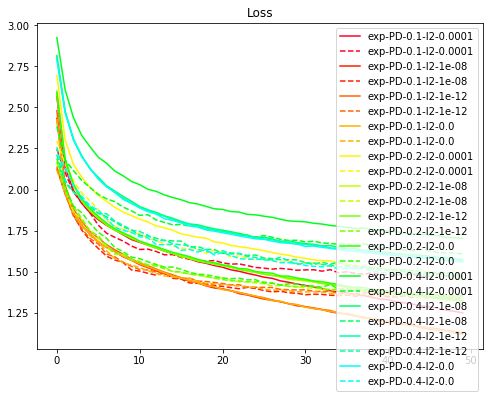

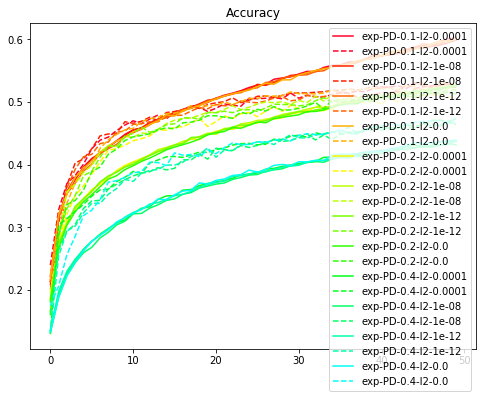

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()